# Практическое задание к уроку 3. Продвинутые архитектуры свёрточных нейросетей

Обучить СНС с помощью Transfer Learning на датасете Food-101

Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.

Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [1]:
# %tensorflow_version 2.x
!pip install tensorflow #==1.15.0
!pip install tensorflow_datasets

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from skimage.transform import resize
from tensorflow.keras import layers

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

## Загрузка датасета Food-101

https://www.tensorflow.org/datasets/catalog/food101

Этот набор данных состоит из 101 категории продуктов питания и 101 000 изображений. Для каждого класса предоставляется 250 проверенных вручную тестовых изображений, а также 750 обучающих изображений. Учебные изображения намеренно не очищались и поэтому все еще содержат некоторое количество шума. В основном это проявляется в виде интенсивных цветов и иногда неправильных этикеток. Все изображения были масштабированы таким образом, чтобы максимальная длина стороны составляла 512 пикселей.

In [4]:
%%time

tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

CPU times: user 52.5 ms, sys: 4.63 ms, total: 57.2 ms
Wall time: 55.6 ms


2022-08-06 08:25:27.998174: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
class_names = ds_info.features['label'].names
print(class_names)
# classes[:10]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [6]:
number_classes = len(class_names)
number_classes

101

In [7]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


## Визуализация датасета Food-101

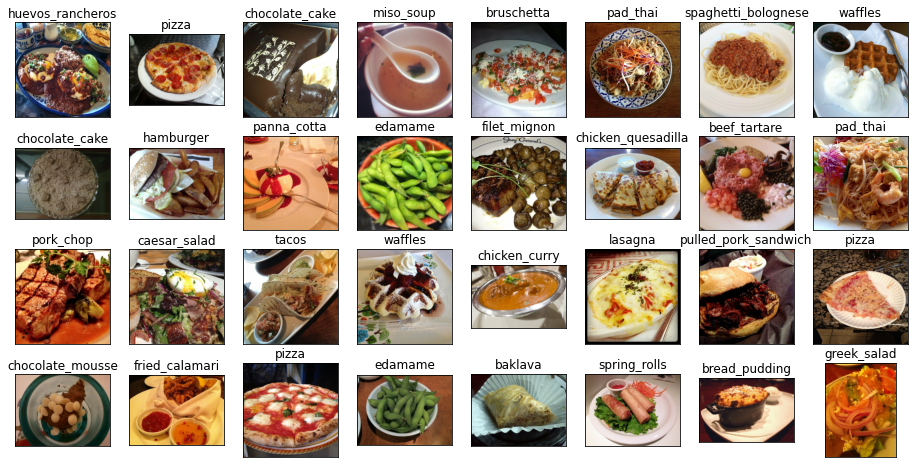

CPU times: user 1.56 s, sys: 174 ms, total: 1.74 s
Wall time: 1.35 s


In [16]:
%%time
# some_samples = [x[0] for x in iter(train_ds.take(32))]
some_samples = [x for x in iter(train_ds.take(32))]

# fig = plt.figure(figsize=(16, 8))
# for j in range(len(some_samples)):
#     ax = fig.add_subplot(4, 8, j+1)
#     ax.imshow(some_samples[j])
#     plt.xticks([]), plt.yticks([])
# plt.show()

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j][0])
    plt.xticks([])
    plt.yticks([])
    plt.title(class_names[some_samples[j][1]])
    plt.grid(False)
plt.show()

## Создание пайплайна данных

Мы используем предобученную модель MobileNet, у неё веса уже сформированы, она ожидает видеть на входе картинки в определённом диапазоне от -1 до 1. Поэтому картинки нужно преобразовать в нужный диапазон.

In [17]:
INP_SIZE = 224 #160
NUM_EPOCHS = 5 #10
BATCH_SIZE = 32

def prepare(img, label): # приводим диапазон 0-255 к диапазону от -1 до 1. Такие картинки нельзя визуализировать.
    # Создаём квадратные картинки с входным размером 224x224.
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)
# test_ds = test_ds.batch(128, drop_remainder=True)

In [18]:
train_ds, test_ds

(<BatchDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.int64)>)

# Подготовка модели CNN

В Keras уже есть готовые модели в tf.keras.applications.

Чтобы запускать модель с нуля или предобученную, нужно после if ставить 1 или 0.

EXP_NAME - имя эксперимента для отображения в TensorBoard.

include_top=False. В исходной модели есть последний слой, называющийся top. Он заточен на классы ImageNet (1000 классов). Если мы не хотим использовать последний слой = False. Т.е. будет возвращатся модель без последнего слоя.

weights - будем использовать преобученные веса или будем обучать модель с нуля (from scratch)

base_model.trainable = True - все веса предобученной модели будут обучаемыми.

Последний слой обучения мы добавим в финальной модели, где у нас три слоя. На выходе первого слоя модели (из base_model) - тензор, который выходит из последнего свёрточного слоя. Чтобы передать этот тензор в Dense слой, мы используем GlobalAveragePooling2D, чтобы сократить все пространственные измерения и получить просто вектор, который передаём в полносвязный слой с одним нейроном и случайными начальными весами.

Во втором случае (Transfer Learning), в отличие от первого (Обучение модели с нуля), мы используем предобученные веса из сети ImageNet: weights='imagenet'.

Для второго случая у нас есть два варианта:

- base_model.trainable = True - это будет Fine-tuning (тонкая настройка) весов предобученной модели т.е. предварительно обученные веса MobileNet мы будем дообучать.

- base_model.trainable = False - если мы хотим заморозить веса предобученной модели. В этом случаем мы будем обучать только параметры последнего слоя tf.keras.layers.Dense(1, activation='sigmoid').

In [19]:
# Регуляризация - наложение ограничений на обучаемые параметры NN (решение проблемы переобучения).

# Вводим для модели L2-регуляризацию (L2 также называется WEIGHT_DECAY)
# т.е. 2-ю норму весов модели стремим к 0
WEIGHT_DECAY = 0.001   # Коэффициент lambda при 2-м слагаемом нашего лосса

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)  # L2(WEIGHT_DECAY) регуляризация

if 0: # Обучение модели с нуля

    EXP_NAME = 'scratch'
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights=None,
    )
    base_model.trainable = True

else: # Transfer Learning
    EXP_NAME = 'transfer'
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,   # Верни модель без последнего слоя (top-слоя).
        weights='imagenet',  # Веса base_model будут предобучены на датасете Imagenet.
    )
    for layer in base_model.layers[:-5]:
      base_model.trainable = True # Fine-tuning весов слоёв предобученной модели

    for layer in base_model.layers[-5:]:
        layer.kernel_regularizer=wd  # применяем L2(WEIGHT_DECAY)-регуляризацию

    data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation((-0.2, 0.2)),
    ])
#     base_model.trainable = True # Fine-tuning весов предобученной модели
    # base_model.trainable = False # Заморозка весов предобученной модели

model = tf.keras.Sequential([
        # augmentation
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.InputLayer(input_shape=(INP_SIZE, INP_SIZE, 3)),
    data_augmentation,
    base_model,  # На выходе модели тензор с пространственными разметрами [7x7x1280 (1280 каналов)]
# делаем собственные слои
    tf.keras.layers.GlobalAveragePooling2D(), # Сокращаем все пространственные измерения и получаем вектор (по каналам)
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=wd),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(101, activation='softmax')
#     tf.keras.layers.Dense(1, activation='sigmoid'),
#     tf.keras.layers.Dense(320, activation='relu'),
#     tf.keras.layers.Dense(1, activation='softmax'),
])

9412608/9406464 [==============================] - 1s 0us/step


## Подготовка к обучению

In [21]:
LEARNING_RATE = 0.0001 #0.0005
optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', #'binary_crossentropy' # многоклассовая классификация
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

/Users/alenakukhta/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Model Summary

Output Shape равный (None, 5, 5, 1280) - это размер выходного тензора: (размер батча, 5х5, 1280 каналов)

После того как мы их усреднили в global_average_pooling2d_1 мы получили вектор: (None, 1280) который состоит из 1280 чисел.

Этот вектор мы передаём в Dense слой, на выходе из которого (None, 1) получаем 1 нейрон.

In [22]:
#model.build((32, 160, 160, 3))
#tf.keras.layers.GlobalAveragePooling2D.build(32, 160, 160, 3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               25957     
Total params: 2,611,877
Trainable params: 2,577,765
Non-trainable params: 34,112
_______________________________________

## Обучение модели

In [23]:
NUM_EPOCHS = 5  # §10 Количество эпох, конечно, нужно добавить.
                # Уменьшила для возможности в срок сдать ДЗ ибо очень долго их модель отрабатывает(

In [24]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/5
2130/2130 [==============================] - 3669s 2s/step - loss: 3.4568 - accuracy: 0.2934 - val_loss: 2.4810 - val_accuracy: 0.4736
Epoch 2/5
2130/2130 [==============================] - 3665s 2s/step - loss: 2.3510 - accuracy: 0.5052 - val_loss: 2.2205 - val_accuracy: 0.5395
Epoch 3/5
2130/2130 [==============================] - 3682s 2s/step - loss: 1.9948 - accuracy: 0.5801 - val_loss: 1.9338 - val_accuracy: 0.6029
Epoch 4/5
2130/2130 [==============================] - 3679s 2s/step - loss: 1.7820 - accuracy: 0.6206 - val_loss: 1.7154 - val_accuracy: 0.6364
Epoch 5/5
2130/2130 [==============================] - 3711s 2s/step - loss: 1.6246 - accuracy: 0.6499 - val_loss: 1.8652 - val_accuracy: 0.6083
CPU times: user 1d 3h 11min 1s, sys: 1h 44min 12s, total: 1d 4h 55min 14s
Wall time: 5h 6min 45s


88005052035 проект

## Оценка качества модели

In [25]:
%%time

model.evaluate(test_ds)

236/236 [==============================] - 80s 335ms/step - loss: 1.8669 - accuracy: 0.6081
CPU times: user 5min 59s, sys: 30.1 s, total: 6min 30s
Wall time: 1min 19s


[1.8669447898864746, 0.6080508232116699]

## TensorBoard

In [26]:
%load_ext tensorboard
%tensorboard --logdir logs

## Запуск предсказания на нашем изображении

--2022-08-06 15:24:39--  https://www.good-menu.ru/img/buterbrody/buterbrod6.jpg
Resolving www.good-menu.ru (www.good-menu.ru)... 45.130.41.42
Connecting to www.good-menu.ru (www.good-menu.ru)|45.130.41.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52615 (51K) [image/jpeg]
Saving to: 'buterbrod6.jpg.3'

buterbrod6.jpg.3    100%[===================>]  51.38K  --.-KB/s    in 0.02s   

2022-08-06 15:24:39 (2.07 MB/s) - 'buterbrod6.jpg.3' saved [52615/52615]

--2022-08-06 15:24:39--  https://www.good-menu.ru/img/carne/carne125.jpg
Resolving www.good-menu.ru (www.good-menu.ru)... 45.130.41.42
Connecting to www.good-menu.ru (www.good-menu.ru)|45.130.41.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94843 (93K) [image/jpeg]
Saving to: 'carne125.jpg.3'

carne125.jpg.3      100%[===================>]  92.62K  --.-KB/s    in 0.02s   

2022-08-06 15:24:40 (5.03 MB/s) - 'carne125.jpg.3' saved [94843/94843]

--2022-08-06 15:24:40--  https:

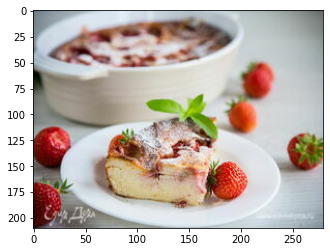

In [27]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

if 1:
    !wget https://www.good-menu.ru/img/buterbrody/buterbrod6.jpg
    !wget https://www.good-menu.ru/img/carne/carne125.jpg
    !wget https://e3.edimdoma.ru/data/recipes/0015/0274/150274-ed4_small.jpg #?1659510201
    !wget https://e0.edimdoma.ru/data/recipes/0015/0256/150256-ed4_small.jpg #?1659105547

# img = imageio.imread('buterbrod6.jpg', pilmode="RGB")
# img = imageio.imread('carne125.jpg', pilmode="RGB")
# img = imageio.imread('150274-ed4_small.jpg', pilmode="RGB")
img = imageio.imread('150256-ed4_small.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [28]:
pred = model(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('Prediction: {}'.format(ds_info.features['label'].int2str(pred_label)))

Prediction: apple_pie


In [29]:
some_samples = []# some_samples = []
some_labels =[] 

for x in iter(test_ds.take(32)):
    some_samples.append(x[0])
    some_labels.append(x[1])

In [30]:
predictions = model.predict(some_samples[0])

In [31]:
prediction_labels = tf.argmax(predictions, axis=1, output_type=tf.int32)

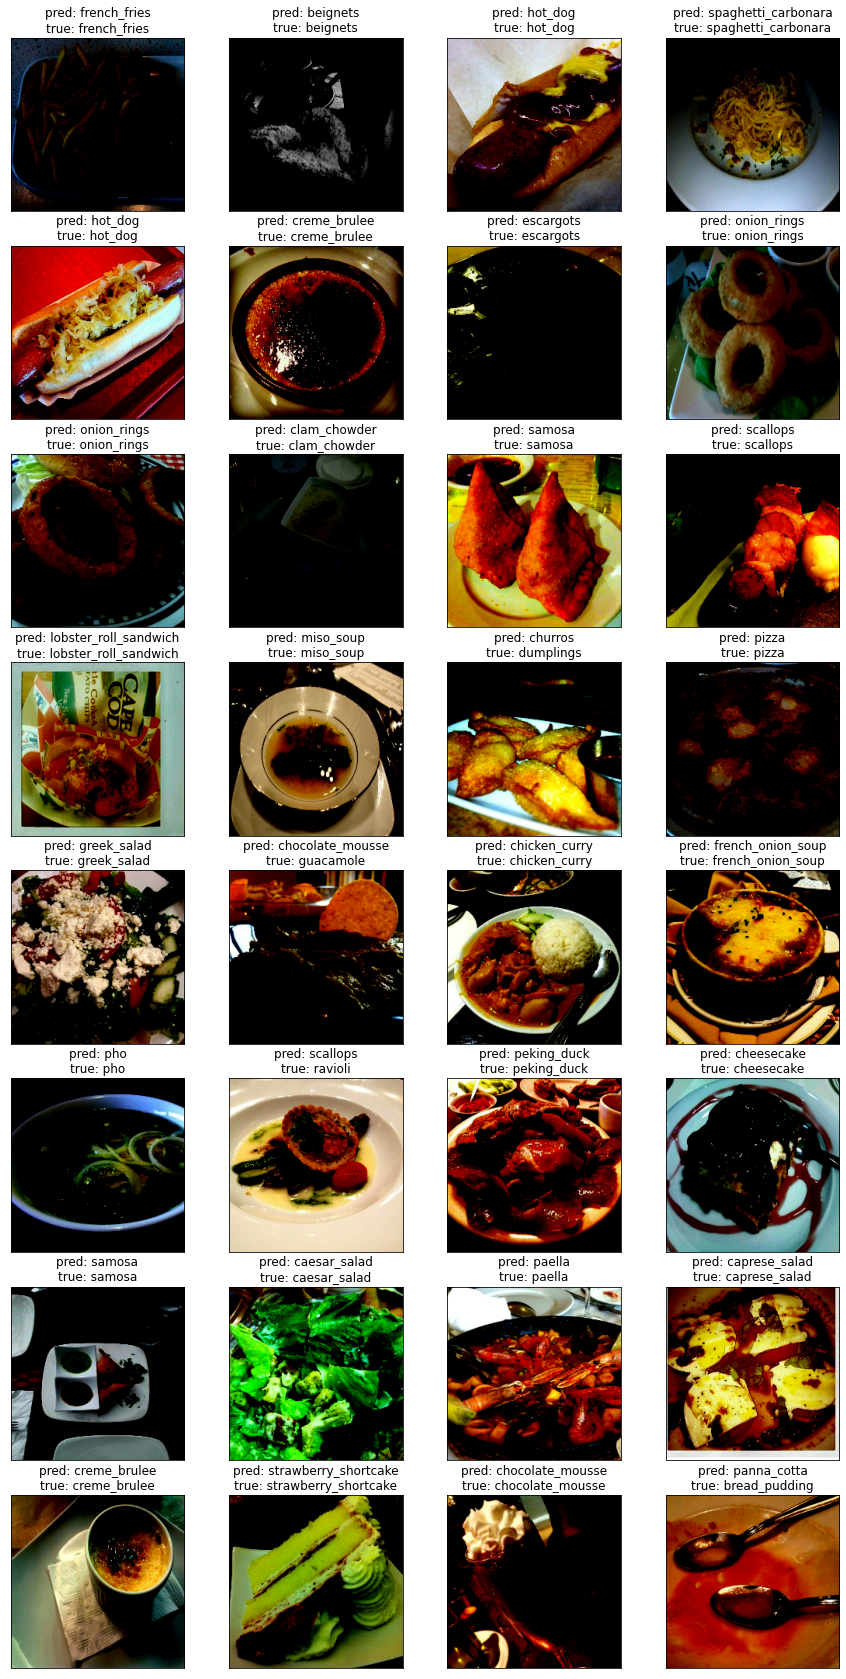

In [32]:
fig = plt.figure(figsize=(15, 30))
for j in range(len(some_samples[0])):
    ax = fig.add_subplot(8, 4, j+1)
    ax.imshow(some_samples[0][j])
    ax.title.set_text(f'pred: {class_names[prediction_labels[j]]}\n' + \
                      f'true: {class_names[some_labels[0][j]]}')
    plt.xticks([]), plt.yticks([])
plt.show()